The following code is going to add your google drive in the notebook

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load the Data
We need to load the data on which we are going to implement the ML algos, for this session, we are going to implement LSTM ML architecture.


In [58]:
import pandas as pd

dataFrame = pd.read_csv('/content/drive/MyDrive/DataVisDataAnalysis/insurance.csv', sep=',')
dataFrame.head() # if a function is returning any value, it directly pass it in the print(), so, we
                  # see the output

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Step 2: Encoding the non-numeric value
WE need to encode the non-numeric features to a one-hot encoded values, where the encoded values are represented by a unique value/bit numbers. Same string will generate same representation.

In [59]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

label_encoders ={} # empty list
categorical_columns = ['sex', 'smoker', 'region']
for col in categorical_columns:
  le = LabelEncoder() # instance of the label encoder
  dataFrame[col] = le.fit_transform(dataFrame[col])
  label_encoders[col]= le

# how does the current dataframe look like
dataFrame.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


In [60]:
# my target is to use minmaxscaler to coverge the highly variated values to the range 0 to 1

scaler = MinMaxScaler()
scaled_DF = scaler.fit_transform(dataFrame)

# the output of the minmax conversion
scaled_DF

array([[0.02173913, 0.        , 0.3212268 , ..., 1.        , 1.        ,
        0.25161076],
       [0.        , 1.        , 0.47914985, ..., 0.        , 0.66666667,
        0.00963595],
       [0.2173913 , 1.        , 0.45843422, ..., 0.        , 0.66666667,
        0.05311516],
       ...,
       [0.        , 0.        , 0.56201238, ..., 0.        , 0.66666667,
        0.00810808],
       [0.06521739, 0.        , 0.26472962, ..., 0.        , 1.        ,
        0.01414352],
       [0.93478261, 0.        , 0.35270379, ..., 1.        , 0.33333333,
        0.44724873]])

### Step 3: Prepare the input feature and output/prediction column

At this step, we need to seperate the dataframe to input features and output prediction part. All the input features will go to the X axis/X column and the prediction/forecasting values will go to the Y column


In [61]:
X = pd.DataFrame(scaled_DF, columns=dataFrame.columns).drop('charges', axis=1)
y = pd.DataFrame(scaled_DF, columns=dataFrame.columns)['charges'].values
y

array([0.25161076, 0.00963595, 0.05311516, ..., 0.00810808, 0.01414352,
       0.44724873])

### Step 4: We need to reshape the X values
Right now, the X values are in 2D shape. LSTM always work with 3D, (samples, timeseries, values). So, we need to covert this 2D shape to 3D one.

For now, the X values have th following shape
(1338, 6).. here 1338 is number of rows and 6 is number of columns... And because we don't have any timeseries values present, we can consider the timeseries as 1, means we are not interested with times, rather we are interested with the values itself from different features

In [62]:
print(X.shape)

import numpy as np
X_lstm = np.reshape(X, (X.shape[0], 1, X.shape[1]))
X_lstm.shape

(1338, 6)


(1338, 1, 6)

### Step 05: Create the model/LSTM model

In [63]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [64]:
modelLSTM = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_lstm.shape[1], X_lstm.shape[2])),
    Dropout(0.2), # 20% of the trained weight is going to be dropped
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Step 06: train/test split
We are now going to divide our data in train set and testing set. For training we are going to use 80% data and for Testing, we will reserve 20% data

In [65]:
split=int(0.8 * len(X)) # we are finding out how many rows will go for 80% data
X_train, X_test = X_lstm[:split], X_lstm[split:] # slicing example
y_train, y_test = y[:split],y[split:]

# Activation function with loss calculation matrix section
modelLSTM.compile(optimizer='adam', loss='mean_squared_error')

history = modelLSTM.fit(X_train,y_train, epochs=35, batch_size=32, validation_data=(X_test, y_test)) # training of the given model

Epoch 1/35
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0518 - val_loss: 0.0278
Epoch 2/35
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0254 - val_loss: 0.0163
Epoch 3/35
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0144 - val_loss: 0.0102
Epoch 4/35
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0116 - val_loss: 0.0095
Epoch 5/35
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0103 - val_loss: 0.0092
Epoch 6/35
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0109 - val_loss: 0.0087
Epoch 7/35
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0095 - val_loss: 0.0086
Epoch 8/35
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0106 - val_loss: 0.0092
Epoch 9/35
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0097 - val_loss: 0.0089
Epoch 10/35
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0090 - val_loss: 0.0086
Epoch 11/35
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0096 - val_loss: 0.0088
Epoch 12/35
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0094 - val_l

### Step 7: Generation of Prediction
Once you got the trained model, next step is to try to generate some prediction about future. If you don't have any value to test, you can use your X_test values to generate prediction and then you can compare it with the real values, y_test to evaluate your model

In [66]:
predicted_charges = modelLSTM.predict(X_test)

# create a place holder based on the original data shape
placeholder = np.zeros((predicted_charges.shape[0], scaled_DF.shape[1]))
placeholder[:,-1] = predicted_charges[:,0]

# inverse this charges to get only the charges value from the prediced 3D output to reform my actual data
predicted_charges = scaler.inverse_transform(placeholder)[:,-1]

placeholder_test = np.zeros((y_test.shape[0], scaled_DF.shape[1]))
placeholder_test[:,-1] = y_test
y_test = scaler.inverse_transform(placeholder_test)[:,-1]

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


### Step 8: Evaluation
For evaluation, we can use mean_squared_error or r-square error to find out how well trained our model is

In [67]:
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score

mse = mean_squared_error(y_test, predicted_charges)
#mae = mean_absolute_error(y_test, predicted_charges)
r2square = r2_score(y_test, predicted_charges)

print(mse)
print(r2square)

28115009.736732624
0.8173495434355342


### Step 09: Visualization
To see how our predicted values and our original values move with ages

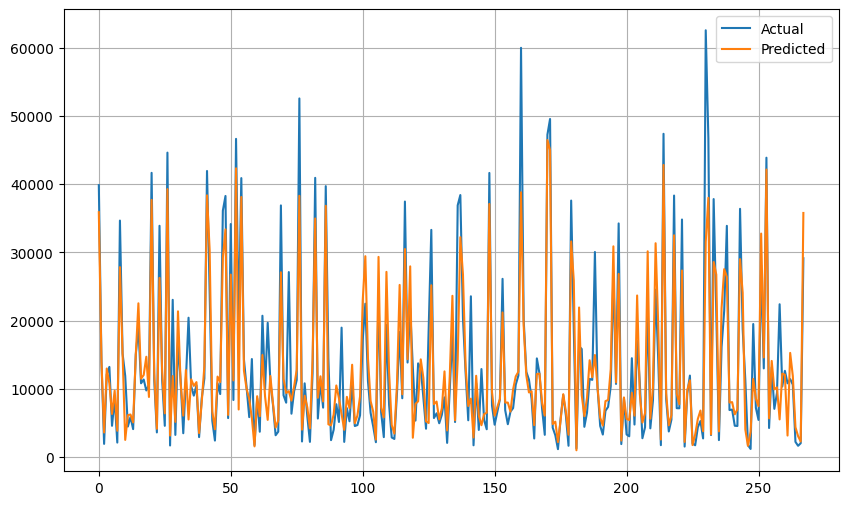

In [68]:
import matplotlib.pyplot as plt

#print(X_test)
plt.figure(figsize=(10,6))
plt.plot(y_test, label='Actual')
plt.plot(predicted_charges, label='Predicted')
plt.title='Actual vs Predicted'
plt.legend()
plt.grid()
plt.show()

### Additional Step: Forecasting the charges with new values
The LSTM model trains on the data pattern and then try to predict the future scenario of the data.. for that reason, we should use different new data and should give it as input to the model to see the future values.

In [72]:
demo_data= pd.DataFrame(
    {
        'age':[30, 42],
        'sex':['male', 'female'],
        'bmi':[25.5, 28.6],
        'children':[2, 3],
        'smoker':['no', 'no'],
        'region':['southeast', 'northwest']
    }
)

for col in categorical_columns:
  demo_data[col]=label_encoders[col].fit_transform(demo_data[col])

# we can add a placeholder for the predicted charges
demo_data['charges']=0

demo_data_scaled = scaler.transform(demo_data)

# reshaping the new data to 3D format
demo_data_scaled = demo_data_scaled[:, :-1]

demo_data_lstm = np.reshape(demo_data_scaled, (demo_data_scaled.shape[0], 1, demo_data_scaled.shape[1]))
demo_data_chargePrediction_s = modelLSTM.predict(demo_data_lstm)
print(demo_data_chargePrediction_s)

# reformulate the predicted charges
placeholder_demo = np.zeros_like(demo_data_scaled)
placeholder_demo[:,-1] = demo_data_chargePrediction_s[:, 0]
demo_data_chargePrediction = scaler.inverse_transform(placeholder_demo)[:, -1]
print(demo_data_chargePrediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[[0.07613823]
 [0.1521743 ]]


ValueError: operands could not be broadcast together with shapes (2,6) (7,) (2,6) 